In [1]:
%run functions.ipynb
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
X_train, X_test, y_train, y_test = load_train_and_test_parts()
print("Train and test sizes: {} {}".format(X_train.shape, X_test.shape))
print(
    "(1, 0) labels count in train test: {} {}".format(
        (np.count_nonzero(y_train == 1), np.count_nonzero(y_train == 0)),
        (np.count_nonzero(y_test == 1), np.count_nonzero(y_test == 0)),
    )
)

Train and test sizes: (726, 12179) (243, 12179)
(1, 0) labels count in train test: (289, 437) (104, 139)


In [3]:
n_iter = 1
cv = 4
n_jobs = 3
scoring = 'roc_auc'

In [4]:
# Parameters
scoring = "recall"
cv = 4
n_iter = 100
n_jobs = 4


In [5]:
print('n_iter: {}\ncv: {}\nn_jobs: {}\nscoring: {}'.format(n_iter, cv, n_jobs, scoring))

n_iter: 100
cv: 4
n_jobs: 4
scoring: recall


In [6]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            num_hidden0=10,
            num_hidden1=10,
            dropout=0.0
    ):
        super().__init__()
        self.num_hidden0 = num_hidden0
        self.num_hidden1 = num_hidden1
        self.dropout = dropout

        self.input_initialized = False
        self.dense0 = None
        self.dropout = nn.Dropout(dropout)
        self.dense1 = nn.Linear(num_hidden0, num_hidden1)
        self.output = nn.Linear(num_hidden1, 2)
        

    def forward(self, X, **kwargs):
        
        if not self.input_initialized:
            self.dense0 = nn.Linear(X.shape[-1], self.num_hidden0)
            self.input_initialized = True
            
        X = F.relu(self.dense0(X))
        X = self.dropout(X)
        X = F.relu(self.dense1(X))
        X = F.softmax(self.output(X), dim=-1)
        return X

In [7]:
early_stopping = EarlyStopping(scoring, patience=10, threshold_mode='abs', threshold=1e-3)
y_train = np.array(y_train, dtype=np.int64)
y_test = np.array(y_test, dtype=np.int64)

## [fDNN](https://www.nature.com/articles/s41598-018-34833-6) model

In [8]:
clf_params = {'lr' : np.linspace(0.0001, 0.1, 50) , 'module__dropout': np.linspace(0.0, 0.5, 10), 'module__num_hidden0': [5, 10, 20, 50], 
              'module__num_hidden1': [5, 10, 20, 50], 'optimizer__weight_decay': [0.001, 0.01, 0.1, 1, 5, 10]}
dim_params = {'n_components' : [100, 250, 500]}

From skorch documentation:

When you use the NeuralNetClassifier, the criterion is set to PyTorch NLLLoss by default. Furthermore, if you don’t change it loss to another criterion, NeuralNetClassifier assumes that the module returns probabilities and will automatically apply a logarithm on them (which is what NLLLoss expects).


In [9]:
red_rf = RepresentationTransformer(RandomForestClassifier(max_depth=5, min_samples_leaf=20, random_state=random_state))
clf = NeuralNetClassifier(ClassifierModule, train_split=None, optimizer=torch.optim.Adam, callbacks=[skorch_scoring[scoring], early_stopping], 
                          max_epochs=1000, verbose=0)
models_rf = fit_dim_reduction_pipeline(red_rf, clf, dim_params, clf_params, X_train, y_train, 
                                       n_iter=n_iter, cv=cv, n_jobs=n_jobs, scoring=scoring)

In [10]:
models_rf = clf_print_scores(models_rf, X_train, y_train, X_test, y_test)
print(models_rf.best_estimator_.steps[1][1], models_rf.best_estimator_.steps[1][1].optimizer_)

Pipeline(memory=None,
     steps=[('dim', RepresentationTransformer(clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_spl...ut_features=2, bias=True)
    (dense0): Linear(in_features=500, out_features=20, bias=True)
  ),
))])


,ROC AUC,Precision,Recall,F1
train,0.416,0.398,1.000,0.569
test,0.436,0.428,1.000,0.599


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModule(
    (dropout): Dropout(p=0.5)
    (dense1): Linear(in_features=20, out_features=5, bias=True)
    (output): Linear(in_features=5, out_features=2, bias=True)
    (dense0): Linear(in_features=500, out_features=20, bias=True)
  ),
) Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 1
)


In [11]:
red_rlr = RepresentationTransformer(RandomLogisticsRegressions(penalty='l1', C=0.5, n_variables=500))
clf = NeuralNetClassifier(ClassifierModule, train_split=None, optimizer=torch.optim.Adam, callbacks=[skorch_scoring[scoring], early_stopping], 
                          max_epochs=1000, verbose=0)
models_rlr = fit_dim_reduction_pipeline(red_rlr, clf, dim_params, clf_params, X_train, y_train, 
                                        n_iter=n_iter, cv=cv, n_jobs=n_jobs, scoring=scoring)

In [12]:
models_rlr = clf_print_scores(models_rlr, X_train, y_train, X_test, y_test)
print(models_rf.best_estimator_.steps[1][1], models_rf.best_estimator_.steps[1][1].optimizer_)

/pio/scratch/1/i272955/anaconda3/envs/master/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Pipeline(memory=None,
     steps=[('dim', RepresentationTransformer(clf=RandomLogisticsRegressions(C=0.5, n_estimators=250, n_variables=500,
              penalty='l1', solver='liblinear', tol=0.0001),
             n_components=250, probabilistic=True)), ('clf', <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  ...ut_features=2, bias=True)
    (dense0): Linear(in_features=250, out_features=20, bias=True)
  ),
))])


/pio/scratch/1/i272955/anaconda3/envs/master/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,ROC AUC,Precision,Recall,F1
train,0.058,0.000,0.000,0.000
test,0.210,0.000,0.000,0.000


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModule(
    (dropout): Dropout(p=0.5)
    (dense1): Linear(in_features=20, out_features=5, bias=True)
    (output): Linear(in_features=5, out_features=2, bias=True)
    (dense0): Linear(in_features=500, out_features=20, bias=True)
  ),
) Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 1
)


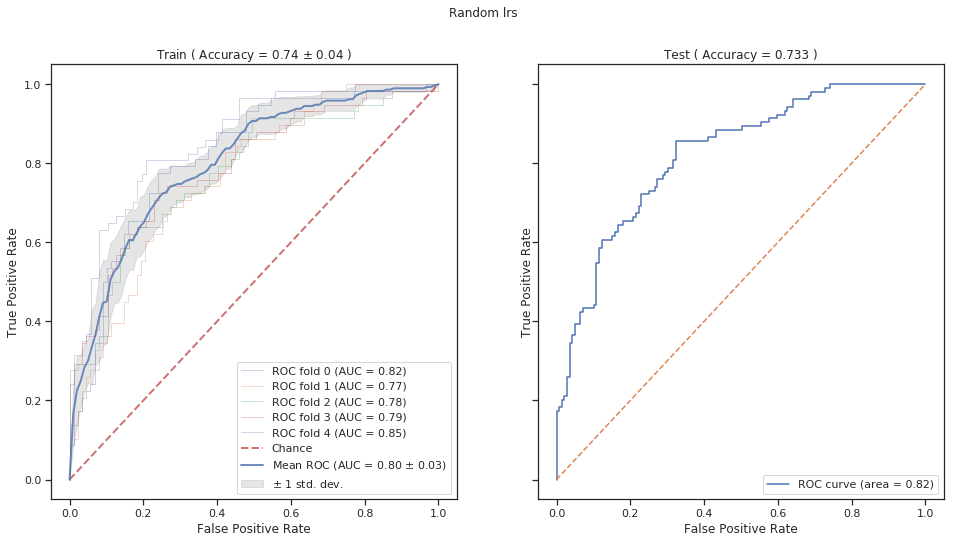

In [13]:
clf_random_lrs = fit_clf_with_cross_val(RandomLogisticsRegressions(n_estimators=21, penalty='l1', C=0.3, n_variables=2000), X_train, y_train, X_test, y_test, title='Random lrs')